# Import Libraries

In [2]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=ffc88f648a991241c52c9542b5ebea05f07d663d81e5a547fdaab5139c4d8b7b
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
import imutils
from skimage import measure

# Preprocessing and other Neccessary Functions

In [4]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
def crop_brain_contour(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    return new_image

# Function to predict tumor presence using CNN classifier

In [6]:
def predict_tumor_presence(image_path, cnn_model):
    
    pred_img = cv2.imread(image_path)
    pred_img = crop_brain_contour(pred_img)
    pred_img = cv2.resize(pred_img,dsize=(224, 224),interpolation=cv2.INTER_CUBIC)
    pred_img = cv2.bilateralFilter(pred_img, 2, 50, 50)
    pred_img = np.array(pred_img)
    pred_img = np.expand_dims(pred_img, axis=0)
    pred_img = pred_img / 255.0

    # Make prediction
    predictions = cnn_model.predict(pred_img)

    # Convert to binary predictions
    pred = (predictions > 0.5).astype(int).flatten()
#     print(pred[0])

    # Output the result
    if pred[0] == 1:
        print('Tumor detected')

    return pred[0]

# Function to segment the image with tumour

In [7]:
def predict_tumor_segmentation(image_path, model):
    # Read the new image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()

    # Preprocess the image (resize, normalize)
    resized_image = cv2.resize(image, (256, 256))
    preprocessed_image = resized_image.astype(np.float32) / 255.0

    # Make prediction
    input_image = np.expand_dims(preprocessed_image, axis=0)
    predicted_mask = model.predict(input_image)[0]

    # Post-process the predicted mask (thresholding, resizing)
    thresholded_mask = (predicted_mask >= 0.5).astype(np.uint8)
    resized_mask = cv2.resize(thresholded_mask, (original_image.shape[1], original_image.shape[0]))

    # Create overlay by highlighting tumor regions on the original image
    overlay = original_image.copy()
    overlay[resized_mask == 1] = (0, 0, 255)  # Highlight tumor regions in red
    
    # Find contours of the tumor region
    contours = measure.find_contours(resized_mask, level=0.5)

    # Fix contour coordinates to match the overlay
    for contour in contours:
        contour = np.flip(contour, axis=1).astype(np.int32)  # Flip the coordinates to match the image orientation
        cv2.polylines(overlay, [contour], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Add transparency (alpha blending) for overlay
    alpha = 0.5
    blended_overlay = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)

    # Normalize the heatmap to the range [0, 1] for proper coloring
    heatmap_mask = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))
    heatmap_mask = np.clip(heatmap_mask, 0, 1)

    # Create the figure to display both visualizations side by side
    plt.figure(figsize=(20, 8))

    # Display the overlayed image with contours
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(blended_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Detected with Overlay and Contour')
    plt.axis('off')

    # Display the heatmap overlayed on the original image
    plt.subplot(1, 2, 2)
    sns.heatmap(heatmap_mask, cmap='jet', alpha=0.6, zorder=2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), alpha=0.4, zorder=1)
    plt.title('Tumor Segmentation Heatmap')
    plt.axis('off')

    plt.show()

# Function to integrate both steps

In [8]:
def detect_and_segment_tumor(image_path, cnn_model, unet_model):
    # Predict tumor presence using CNN classifier
    classification_result = predict_tumor_presence(image_path, cnn_model)

    if classification_result > 0.5:  # If tumor is predicted
        # Predict tumor segmentation using U-Net
        overlayed_image = predict_tumor_segmentation(image_path, unet_model)
    else:
        print("No tumor detected.")
        return None

# Load Classification and Segmentation Models

In [9]:
# Load your trained models
classification_model = load_model('/kaggle/input/classification-model/classification_model/classification_best.h5')

with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    segmentation_model = tf.keras.models.load_model('/kaggle/input/segmentation-model/segmentation_model/segmentation.h5')

# Testing on new data (pred folder)

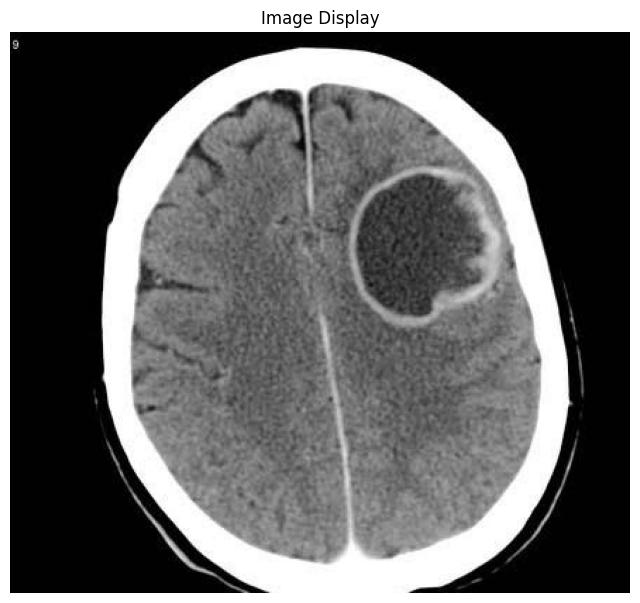

In [24]:
def plot_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.title('Image Display')
    plt.axis('off')  # Turn off axis
    plt.show()

image_path = '/kaggle/input/dataset/Br35H/pred/pred10.jpg'
plot_image(image_path)

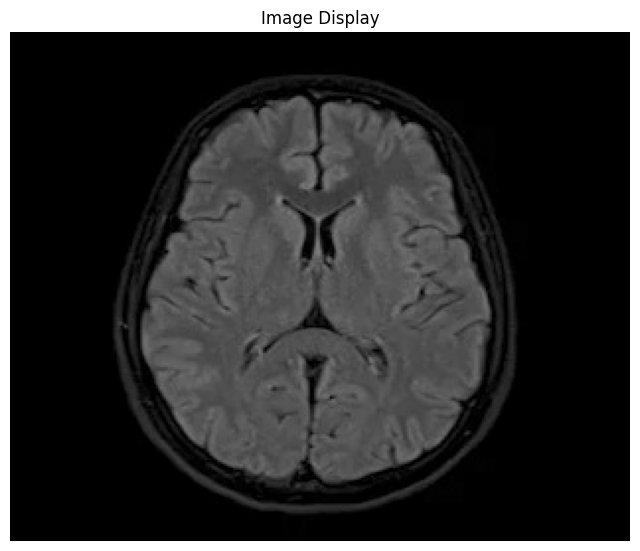

In [26]:
image_path = '/kaggle/input/dataset/Br35H/pred/pred0.jpg'
plot_image(image_path)

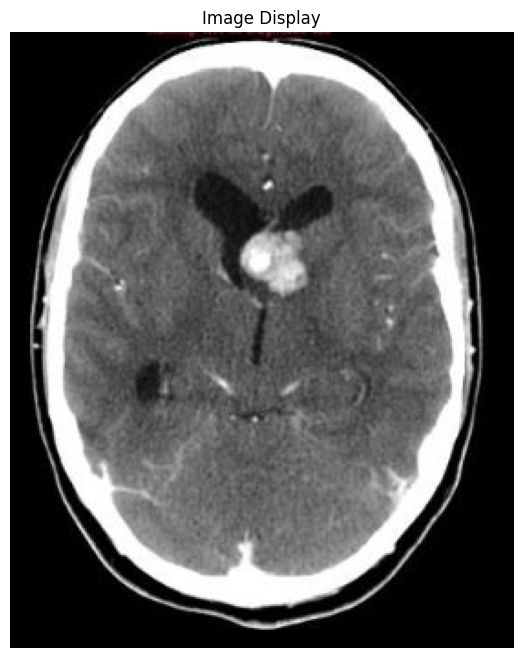

In [25]:
image_path = '/kaggle/input/dataset/Br35H/pred/pred30.jpg'
plot_image(image_path)

## Classification

In [14]:
classification_result = predict_tumor_presence('/kaggle/input/dataset/Br35H/pred/pred10.jpg', classification_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Tumor detected


## Segmentation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


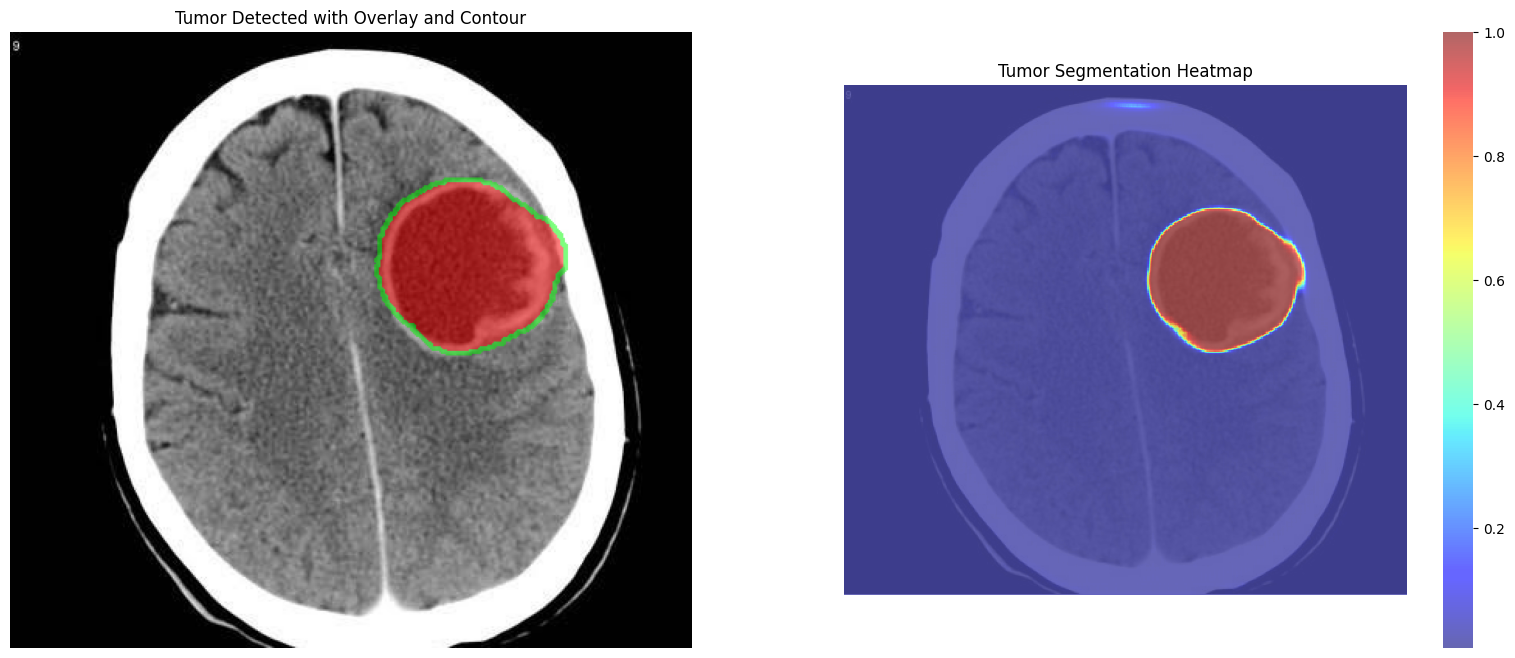

In [20]:
predict_tumor_segmentation('/kaggle/input/dataset/Br35H/pred/pred10.jpg', segmentation_model)

## Integration (Prototype)

### Example 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


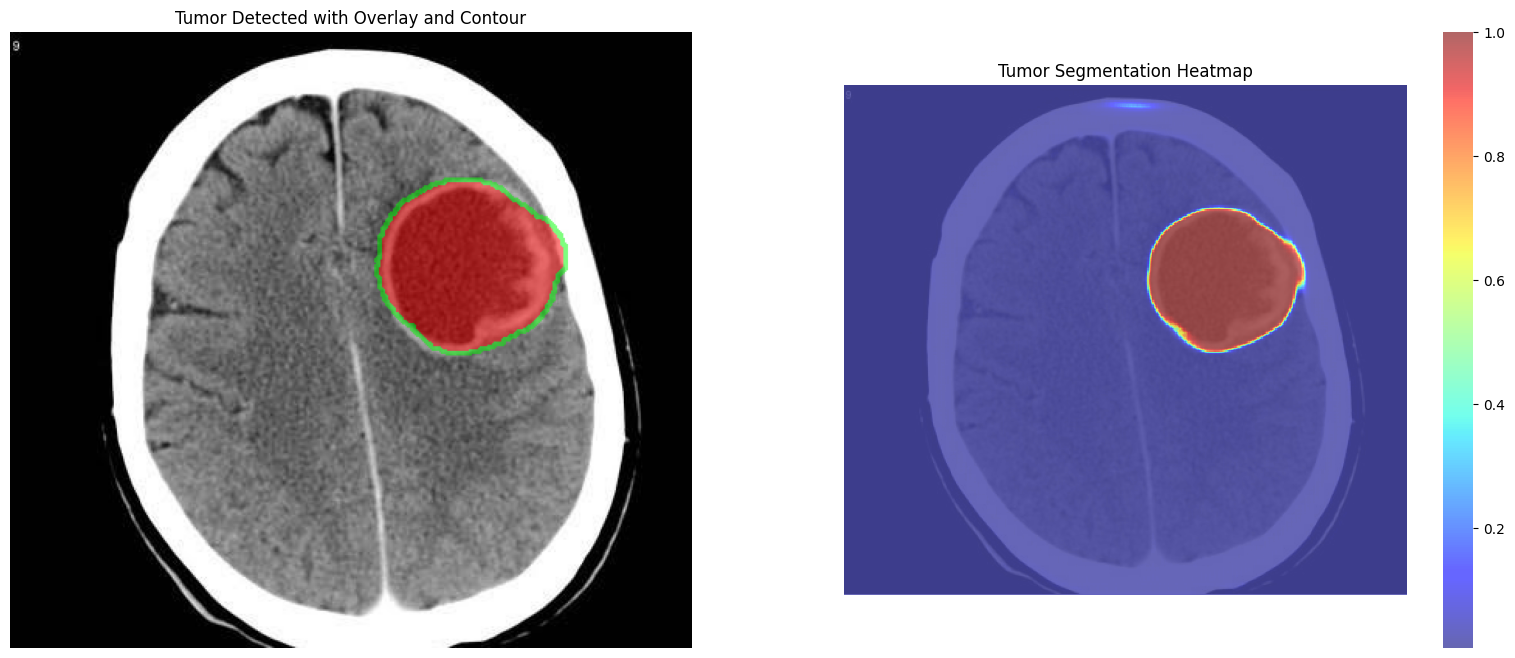

In [21]:
detect_and_segment_tumor('/kaggle/input/dataset/Br35H/pred/pred10.jpg', classification_model, segmentation_model)

### Example 2

In [22]:
detect_and_segment_tumor('/kaggle/input/dataset/Br35H/pred/pred0.jpg', classification_model, segmentation_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
No tumor detected.


### Example 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tumor detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


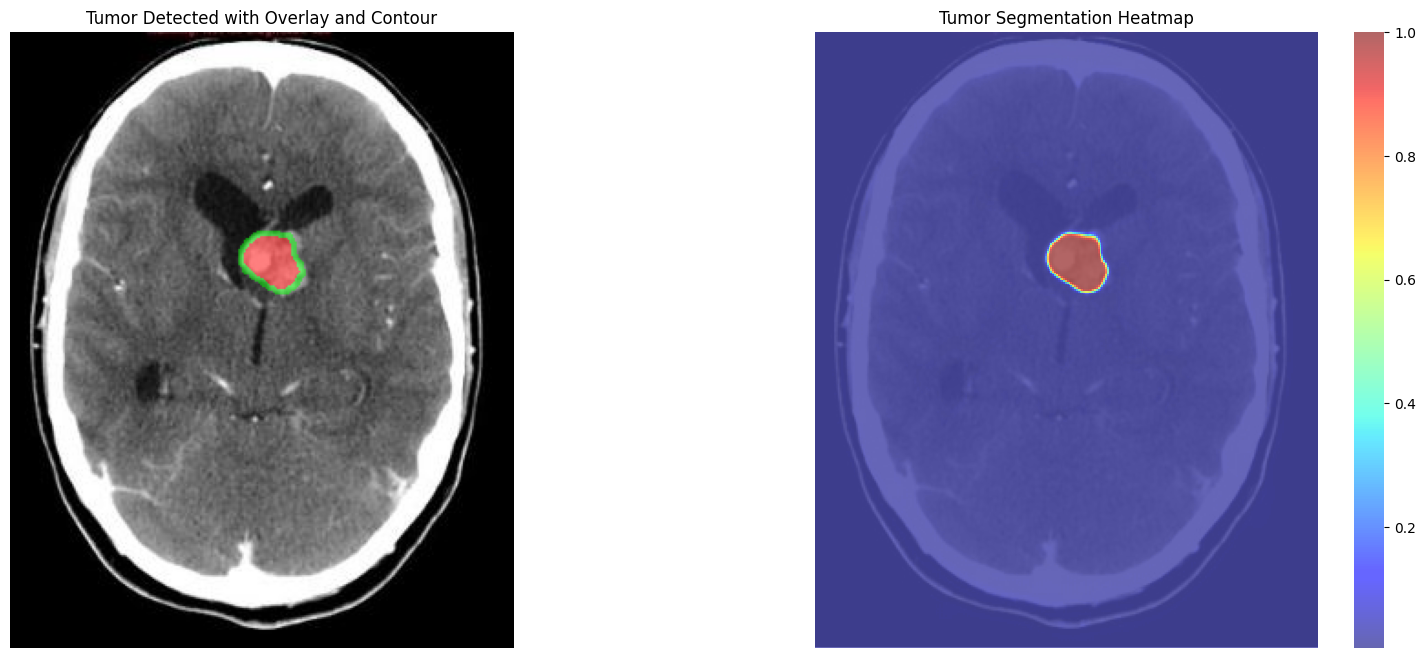

In [23]:
detect_and_segment_tumor('/kaggle/input/dataset/Br35H/pred/pred30.jpg', classification_model, segmentation_model)